# Tesing the Dynamic KWS DataLoader

In [3]:
import os
import sys

import numpy as np
import torch

import matplotlib.pyplot as plt

import scipy.io.wavfile as wav

import importlib
import librosa

import IPython
from scipy.io.wavfile import write
import librosa
import pytsmod as tsm
import soundfile as sf

In [4]:
data_file = 'dataset1.pt'
processed_folder = '/home/merveeyuboglu/Github/ai8x-training/data/KWS/processed'
data, targets, data_type = torch.load(os.path.join(processed_folder, data_file))

In [4]:
print(f'data shape: {data.shape}')
print(f'audio size: {data[0].shape}')

data shape: torch.Size([126451, 16384])
audio size: torch.Size([16384])


### Testing the previous saved raw dataset and its targets for approval

In [5]:
def plot_audio(data):
    plt.plot(data)
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.show()

#### -example 1

In [6]:
write('test.wav', 16000, np.array(data[6]))
print(f'target class info: {targets[6]}')
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav')

target class info: tensor([0], dtype=torch.uint8)


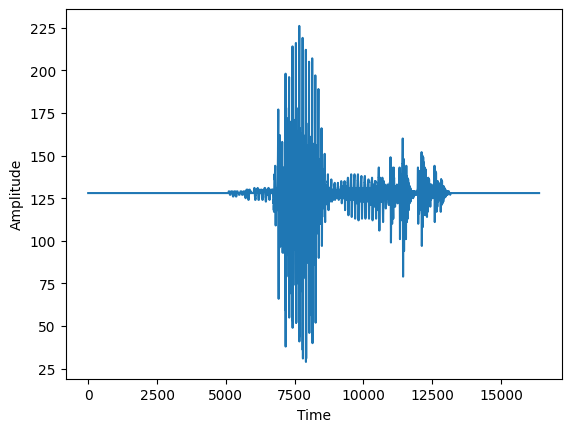

In [7]:
plot_audio(data[6])

#### -example 2

In [8]:
write('test.wav', 16000, np.array(data[15245]))
print(f'target class info: {targets[15245]}')
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav')

target class info: tensor([6], dtype=torch.uint8)


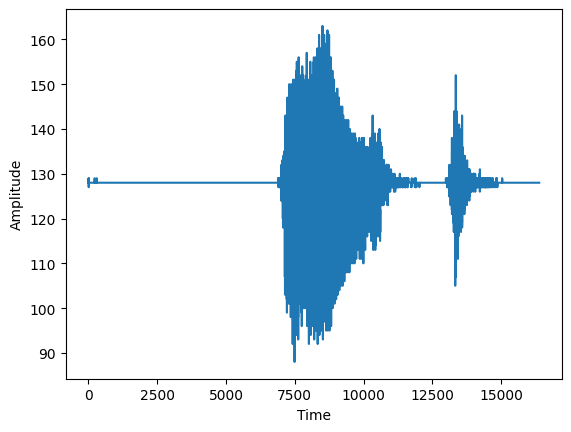

In [9]:
plot_audio(data[15245])

### Testing the augmented audios

In [10]:
augmentation = {'aug_num': 2, 'shift': {'min': -0.15, 'max': 0.15},'noise_var': {'min': 0, 'max': 1}, 'strech' : {'min': 0.8, 'max': 1.3}}

def add_white_noise(audio, noise_var_coeff):
    """Adds zero mean Gaussian noise to image with specified variance.
    """
    coeff = noise_var_coeff * np.mean(np.abs(audio))
    noisy_audio = audio + coeff * np.random.randn(len(audio))
    return noisy_audio

def shift(audio, shift_sec, fs):
    """Shifts audio.
    """
    shift_count = int(shift_sec * fs)
    return np.roll(audio, shift_count)

def stretch(audio, rate=1):
    """Stretches audio with specified ratio.
    """
    input_length = 16000
    audio2 = librosa.effects.time_stretch(audio, rate)
    if len(audio2) > input_length:
        audio2 = audio2[:input_length]
    else:
        audio2 = np.pad(audio2, (0, max(0, input_length - len(audio2))), "constant")

    return audio2

def augment(audio, fs = 16000, verbose=False):
    """Augments audio by adding random noise, shift and stretch ratio.
    """
    random_noise_var_coeff = np.random.uniform(augmentation['noise_var']['min'],
                                                augmentation['noise_var']['max'])
    random_shift_time = np.random.uniform(augmentation['shift']['min'],
                                            augmentation['shift']['max'])
    random_strech_coeff = np.random.uniform(augmentation['strech']['min'],
                                            augmentation['strech']['max'])

    aug_audio = tsm.wsola(audio, random_strech_coeff)
    aug_audio = shift(aug_audio, random_shift_time, fs)
    #aug_audio = add_white_noise(aug_audio, random_noise_var_coeff)

    if verbose:
        print(f'random_noise_var_coeff: {random_noise_var_coeff:.2f}\nrandom_shift_time: \
                {random_shift_time:.2f}\nrandom_strech_coeff: {random_strech_coeff:.2f}')
    return aug_audio

In [11]:
def dynamic_augment(record, fs = 16000, verbose=False, exp_len=16384, row_len=128, overlap_ratio=0):
        
        audio = augment(record, fs)

        overlap = int(np.ceil(row_len * overlap_ratio))
        num_rows = int(np.ceil(exp_len / (row_len - overlap)))
        data_len = int((num_rows * row_len - (num_rows - 1) * overlap))

        data_in = np.empty((row_len, num_rows), dtype=np.uint8)
            
        for n_r in range(num_rows):
            start_idx = n_r * (row_len - overlap)
            end_idx = start_idx + row_len
            audio_chunk = audio[start_idx:end_idx]
            audio_chunk = np.pad(audio_chunk, [0, row_len - audio_chunk.size])
            data_idx = n_r
            data_in[:, data_idx] = audio_chunk

        data_in = torch.from_numpy(data_in)
            
        return data_in

### -example 3 without adding white noise

In [12]:
audio = np.array(dynamic_augment(data[6])).flatten('F')

In [13]:
write('test.wav', 16384, audio)
print(f'target class info: {targets[6]}')
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav')

target class info: tensor([0], dtype=torch.uint8)


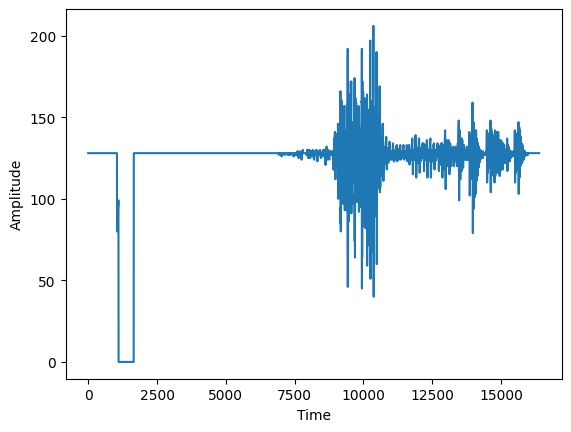

In [14]:
plot_audio(audio)

### -example 4 with adding white noise

In [15]:
def augment(audio, fs = 16000, verbose=False):
    """Augments audio by adding random noise, shift and stretch ratio.
    """
    random_noise_var_coeff = np.random.uniform(augmentation['noise_var']['min'],
                                                augmentation['noise_var']['max'])
    random_shift_time = np.random.uniform(augmentation['shift']['min'],
                                            augmentation['shift']['max'])
    random_strech_coeff = np.random.uniform(augmentation['strech']['min'],
                                            augmentation['strech']['max'])

    aug_audio = tsm.wsola(audio, random_strech_coeff)
    aug_audio = shift(aug_audio, random_shift_time, fs)
    aug_audio = add_white_noise(aug_audio, random_noise_var_coeff)

    if verbose:
        print(f'random_noise_var_coeff: {random_noise_var_coeff:.2f}\nrandom_shift_time: \
                {random_shift_time:.2f}\nrandom_strech_coeff: {random_strech_coeff:.2f}')
    return aug_audio

In [16]:
audio = np.array(dynamic_augment(data[6])).flatten('F')

In [17]:
write('test.wav', 16384, audio)
print(f'target class info: {targets[6]}')
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav')

target class info: tensor([0], dtype=torch.uint8)


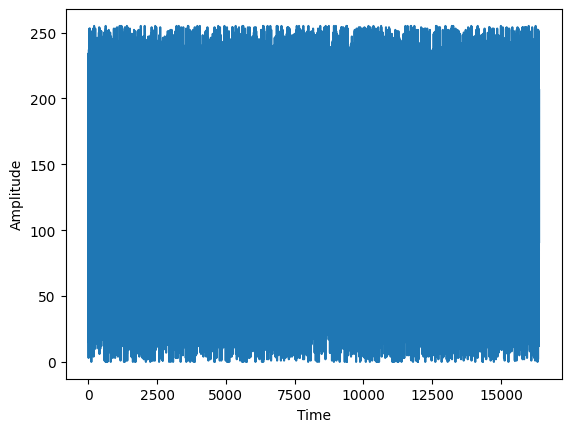

In [18]:
plot_audio(audio)

## Kod deneme

In [23]:
#ornek 10000, target 5 -- down

data_file = 'inp.pt'
processed_folder = '/home/merveeyuboglu/Github/ai8x-training/data/'
data = torch.load(os.path.join(processed_folder, data_file))

In [24]:
data.shape

torch.Size([16384])

In [25]:
write('test.wav', 16384, np.array(data))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav')

# deneme

In [80]:
data_file = 'record.pt'
processed_folder = '/home/merveeyuboglu/Github/ai8x-training/data/'
data = torch.load(os.path.join(processed_folder, data_file))

write('/home/merveeyuboglu/Github/ai8x-training/data/test.wav', 16384, np.array(data))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/data/test.wav')

In [81]:
data_file = 'audio.pt'
processed_folder = '/home/merveeyuboglu/Github/ai8x-training/data/'
data = torch.load(os.path.join(processed_folder, data_file))

write('/home/merveeyuboglu/Github/ai8x-training/data/test.wav', 16384, np.array(data))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/data/test.wav')

In [83]:
data_file = 'data_son.pt'
processed_folder = '/home/merveeyuboglu/Github/ai8x-training/data/'
data = torch.load(os.path.join(processed_folder, data_file))

write('/home/merveeyuboglu/Github/ai8x-training/data/test.wav', 16384, np.array(data).flatten('F'))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/data/test.wav')

In [95]:
data_file = '23945_data.pt'
processed_folder = '/home/merveeyuboglu/Github/ai8x-training/data/'
data = torch.load(os.path.join(processed_folder, data_file))

write('/home/merveeyuboglu/Github/ai8x-training/data/test.wav', 16384, np.array(data))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/data/test.wav')

In [96]:
data_file = '25711_data.pt'
processed_folder = '/home/merveeyuboglu/Github/ai8x-training/data/'
data = torch.load(os.path.join(processed_folder, data_file))

write('/home/merveeyuboglu/Github/ai8x-training/data/test.wav', 16384, np.array(data))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/data/test.wav')

In [97]:
data_file = '24747_data.pt'
processed_folder = '/home/merveeyuboglu/Github/ai8x-training/data/'
data = torch.load(os.path.join(processed_folder, data_file))

write('/home/merveeyuboglu/Github/ai8x-training/data/test.wav', 16384, np.array(data))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/data/test.wav')